In [11]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torchvision import datasets

from pathlib import Path

In [12]:
data_path = Path("../data/p1ch7/")
cifar10 = datasets.CIFAR10(data_path, train = True, download= True)
cifar10_val = datasets.CIFAR10(data_path, train = False, download= True)

Files already downloaded and verified
Files already downloaded and verified


In [13]:
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

In [14]:
label_map = {0:0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label]) for img, label in cifar10 if label in [0, 2]]
cifar2_val = [(img, label_map[label]) for img, label in cifar10_val if label in [0, 2]]

In [15]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size = 64, shuffle = True)

In [16]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size = 64, shuffle=False)

In [17]:
img, _ = cifar2[0]

In [20]:
conv =  nn.Conv2d(3, 16, kernel_size=3)

In [21]:
output = conv(img.unsqueeze(0))

In [22]:
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

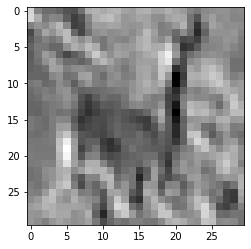

In [23]:
plt.imshow(output[0,0].detach(), cmap="gray")
plt.show()

In [25]:
conv = nn.Conv2d(3,1, kernel_size=3, padding=1)
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

In [27]:
with torch.no_grad():
    conv.bias.zero_()
    
with torch.no_grad():
    conv.weight.fill_(1.0 / 9.0)

In [31]:
img.shape, img.unsqueeze(0).shape, img.unsqueeze(-1).shape # unsqueeze add an extra dimension at idx...

(torch.Size([3, 32, 32]),
 torch.Size([1, 3, 32, 32]),
 torch.Size([3, 32, 32, 1]))

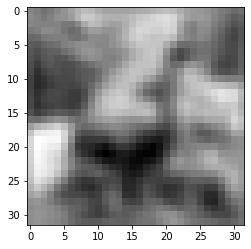

In [32]:
output = conv(img.unsqueeze(0))
plt.imshow(output[0,0].detach(), cmap="gray")
plt.show()

In [35]:
conv = nn.Conv2d(3,1, kernel_size = 3, padding = 1)

with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0], 
                                   [-1.0, 0.0, 1.0], 
                                   [-1.0, 0.0, 1.0]])
    
    conv.bias.zero_()


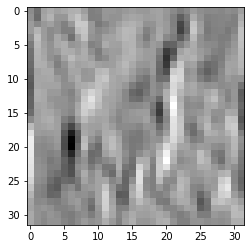

In [36]:
output = conv(img.unsqueeze(0))
plt.imshow(output[0,0].detach(), cmap="gray")
plt.show()

In [38]:
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

## Putting it all together 

In [40]:
#Instead of Softmax and NLLLoss we can combine and use CrossEntropyLoss

model = nn.Sequential(nn.Conv2d(3, 16, kernel_size = 3, padding = 1),
                      nn.Tanh(), 
                      nn.MaxPool2d(2),
                      nn.Conv2d(16, 8, kernel_size = 3, padding = 1),
                      nn.Tanh(),
                      nn.MaxPool2d(2),
                      ## Need to add a subclass to reshape
                      nn.Linear(8*8*8, 32),
                      nn.Tanh(),
                      nn.Linear(32, 2)
                     )

loss_fn = nn.CrossEntropyLoss()

In [1]:
## Not so fast...

## Create our network as an nn.Module

The Net class is equivalent to the nn.Sequential model but we can explicitly manipulate the output of self.pool3

In [7]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size = 3, padding = 1) # Input: (3 channel, 32 x 32) Output: (16 channel, 32x32)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2) #Output: 16C x 16 x 16
        self.conv2 = nn.Conv2d(16, 8, kernel_size = 3, padding = 1) # Input: (16C x 16 x 16) Output: (8C x 16 x 16)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2) # Output: 8C x 8 x 8
        self.fc1 = nn.Linear(8*8*8, 32) # Output: (1 x 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2) # Output: (1 x 2)
        
    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8*8*8) # What we were missing before. Converts to a 
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out
    

Important: 

Our goal is reflected by the size of our intermediate values generally
shrinking—this is done by reducing the number of channels in the convolutions, by
reducing the number of pixels through pooling, and by having an output dimension
lower than the input dimension in the linear layers. This is a common trait of
classification networks. However, in many popular architectures like the ResNets we saw
in chapter 2 and discuss more in section 8.5.3, the reduction is achieved by pooling in
the spatial resolution, but the number of channels increases (still resulting in a
reduction in size). It seems that our pattern of fast information reduction works well
with networks of limited depth and small images; but for deeper networks, the decrease
is typically slower.

Second, in one layer, there is not a reduction of output size with regard to input
size: the initial convolution. If we consider a single output pixel as a vector of 32 ele-
ments (the channels), it is a linear transformation of 27 elements (as a convolution of
3 channels × 3 × 3 kernel size)—only a moderate increase. In ResNet, the initial con-
volution generates 64 channels from 147 elements (3 channels × 7 × 7 kernel size). 6
So the first layer is exceptional in that it greatly increases the overall dimension (as in
channels times pixels) of the data flowing through it, but the mapping for each out-
put pixel considered in isolation still has approximately as many outputs as inputs.

## Simplify

In [8]:
import torch.nn.functional as F

In [9]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size = 3, padding = 1)
        self.fc1 = nn.Linear(8*8*8, 32)
        self.fc2 = nn.Linear(32, 2)
    
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8*8*8) # What we were missing before. Converts to a 
        out = torch.tanh((self.fc1(out)))
        out = self.fc2(out)
        return out

In [18]:
model = Net()
model(img.unsqueeze(0))

tensor([[-0.0262,  0.0429]], grad_fn=<AddmmBackward>)

## Now lets run

In [27]:
import datetime

In [28]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader: # Loops over our dataset in the batches the data loader creates for us
            
            outputs = model(imgs) # feeds a batch through our model
            
            loss = loss_fn(outputs, labels) # computes the loss we wish to minimize
            
            optimizer.zero_grad() # After getting rid of the gradients from the last round
            
            loss.backward() # performs the backward step. Computes gradients
            
            optimizer.step() # updates the model
            
            loss_train += loss.item() # Sums the losses over the epoch
             
        if epoch == 1 or epoch %10 == 0:
            print(f'{datetime.datetime.now()} Epoch {epoch}, Training Loss {loss_train/len(train_loader)}') # Divides by the length of training data loader

In [29]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size = 64, shuffle = True)

model = Net()
optimizer = optim.SGD(model.parameters(), lr = 1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(n_epochs = 100, 
              optimizer = optimizer, 
              model = model, 
              loss_fn = loss_fn, 
              train_loader = train_loader
             )

2020-07-30 19:39:21.385644 Epoch 1, Training Loss 0.5432194188521926
2020-07-30 19:39:46.647205 Epoch 10, Training Loss 0.3215288723919802
2020-07-30 19:40:20.222261 Epoch 20, Training Loss 0.2971838532359737
2020-07-30 19:40:56.640202 Epoch 30, Training Loss 0.2770054606115742
2020-07-30 19:41:31.021992 Epoch 40, Training Loss 0.25808606263558576
2020-07-30 19:42:02.347880 Epoch 50, Training Loss 0.2386671416224188
2020-07-30 19:42:33.350180 Epoch 60, Training Loss 0.22322263312377746
2020-07-30 19:43:03.658713 Epoch 70, Training Loss 0.20428616121696058
2020-07-30 19:43:32.549143 Epoch 80, Training Loss 0.19093755732296377
2020-07-30 19:44:01.620535 Epoch 90, Training Loss 0.17797070065406478
2020-07-30 19:44:30.923696 Epoch 100, Training Loss 0.16130188031561055


## Measure accuracy

In [34]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size = 64, shuffle = False)

def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0
        
        with torch.no_grad(): # We do not want gradients here. Not update parameters
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim = 1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum()) # Cast to a python int which is eqivalent to using .item()
        
        print(f"Accuracy {name}: {correct/total:.2f}")

In [35]:
validate(model, train_loader, val_loader)

Accuracy train: 0.94
Accuracy val: 0.89


## Save and loading our model

Save model with just weights, no struture. This means when we deploy the model in production we'll need to keep the model class handy, create an instance and then load the parameters back in. 

In [37]:
torch.save(model.state_dict(), Path('../models') /'birds_vs_airplanes.pt')

In [38]:
loaded_model = Net()
loaded_model.load_state_dict(torch.load(Path('../models/birds_vs_airplanes.pt')))

<All keys matched successfully>

## Move to GPU if available

In [39]:
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f'Training on device: {device}')

Training on device: cpu


In [41]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader, device):
    print(f'Training on device: {device}')
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader: # Loops over our dataset in the batches the data loader creates for us
            imgs = imgs.to(device = device)
            labels = labels.to(device = device)
            outputs = model(imgs) # feeds a batch through our model
            
            loss = loss_fn(outputs, labels) # computes the loss we wish to minimize
            
            optimizer.zero_grad() # After getting rid of the gradients from the last round
            
            loss.backward() # performs the backward step. Computes gradients
            
            optimizer.step() # updates the model
            
            loss_train += loss.item() # Sums the losses over the epoch
             
        if epoch == 1 or epoch %10 == 0:
            print(f'{datetime.datetime.now()} Epoch {epoch}, Training Loss {loss_train/len(train_loader)}')
            
def validate(model, train_loader, val_loader, device):
    print(f'Validating on device: {device}')
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0
        
        with torch.no_grad(): # We do not want gradients here. Not update parameters
            for imgs, labels in loader:
                imgs = imgs.to(device = device)
                labels = labels.to(device = device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim = 1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum()) # Cast to a python int which is eqivalent to using .item()
        
        print(f"Accuracy {name}: {correct/total:.2f}")            

In [43]:
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))

model = Net().to(device=device)

optimizer = optim.SGD(model.parameters(), lr = 1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(n_epochs = 150, 
              optimizer = optimizer, 
              model = model, 
              loss_fn = loss_fn, 
              train_loader = train_loader,
              device = device
             )

validate(model, train_loader, val_loader, device = device)

Training on device: cpu
2020-07-30 19:57:02.319873 Epoch 1, Training Loss 0.5888296392313235
2020-07-30 19:57:29.241184 Epoch 10, Training Loss 0.3416705160004318
2020-07-30 19:57:55.973133 Epoch 20, Training Loss 0.3038936392137199
2020-07-30 19:58:29.083305 Epoch 30, Training Loss 0.2781128836617728
2020-07-30 19:58:58.490721 Epoch 40, Training Loss 0.2590417129218958
2020-07-30 19:59:26.471722 Epoch 50, Training Loss 0.23878861479698474
2020-07-30 19:59:55.473393 Epoch 60, Training Loss 0.22182096697532447
2020-07-30 20:00:25.010400 Epoch 70, Training Loss 0.20277301245813917
2020-07-30 20:00:54.537306 Epoch 80, Training Loss 0.18896448972878183
2020-07-30 20:01:23.122081 Epoch 90, Training Loss 0.17564612036203123
2020-07-30 20:01:53.061770 Epoch 100, Training Loss 0.1623483489320916
2020-07-30 20:02:21.879279 Epoch 110, Training Loss 0.15035343445410396
2020-07-30 20:02:50.617864 Epoch 120, Training Loss 0.13629933094285476
2020-07-30 20:03:19.572419 Epoch 130, Training Loss 0.127

In [44]:
torch.save(model.state_dict(), Path('../models') /'birds_vs_airplanes.pt')

In [45]:
# Explicityl label PyTorch to override the device info when loading weights via map location
loaded_model = Net().to(device=device)
loaded_model.load_state_dict(torch.load(Path('../models') /'birds_vs_airplanes.pt', map_location=device))

<All keys matched successfully>

## Add skip connection

In [47]:
class NetDepth(nn.Module):
    def __init__(self, n_chans1 = 32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1//2, kernel_size = 3, padding = 1)
        self.conv3 = nn.Conv2d(n_chans1//2, n_chans1//2, kernel_size = 3, padding = 1)
        self.fc1 = nn.Linear(4*4*n_chans1//2, 32)
        self.fc2 = nn.Linear(32, 2)
    
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out1 = out
        out = F.max_pool2d(torch.relu(self.conv3(out)) + out1, 2) # Add the output of the first layer in teh forward function to the input of the third layer. A "residual"
        out = out.view(-1, 4*4*self.n_chans1//2) 
        out = torch.relu((self.fc1(out)))
        out = self.fc2(out)
        return out